In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

#Plotting Style
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

In [2]:
#Loading Dataset
data = pd.read_csv(r"C:\Users\Aditya\Desktop\My Projects\House Price Prediction\house-prices-advanced-regression-techniques\train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#Exploratory Data Analysis (EDA)
#Dataset Info
print("Dataset Shape:", data.shape)
data.info()

#Check Missing Values
missing = data.isnull().sum().sort_values(ascending=False)
missing = missing[missing>0]

Dataset Shape: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-nu

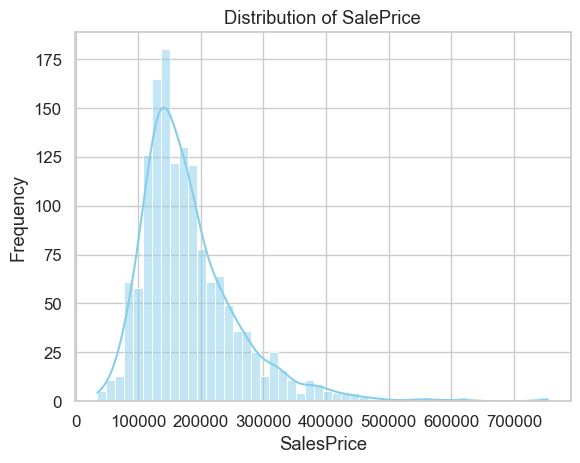

In [5]:
#Target Variable Distribution
sns.histplot(data['SalePrice'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalesPrice')
plt.ylabel('Frequency')
plt.show()

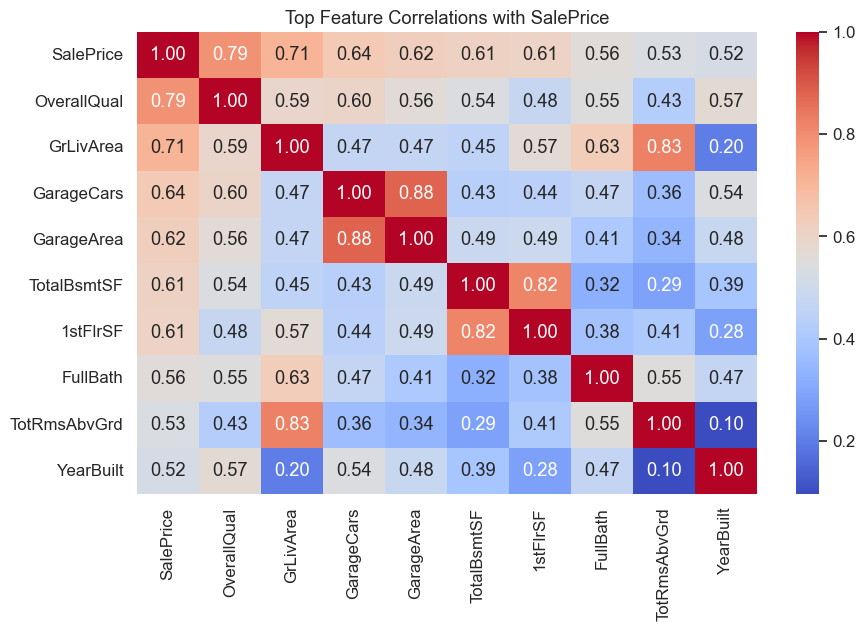

In [6]:
#Correlation heatmap for top features

#Select only numerical features
numerical_data = data.select_dtypes(include=['int64','float64'])

#Compute Correlation
corr = numerical_data.corr()

#Top 10 features correlated with SalesPrice
top_corr_features = corr['SalePrice'].abs().sort_values(ascending=False).head(10).index

#Plot Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numerical_data[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Feature Correlations with SalePrice")
plt.show()

In [7]:
#Data Preprocessing
#Split features and target
X = data.drop(['Id', 'SalePrice'], axis=1)
Y = data['SalePrice']

#Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64','float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

#Fill missing values
X[num_features] = X[num_features].fillna(X[num_features].median())
X[cat_features] = X[cat_features].fillna('Missing')

#Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
#Feature Engineering
#Coloumn transformer for preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
]) 

In [10]:
#Model Training and Evaluation
#Helper function for model training and evaluation
def train_evaluate_model(model, X_train, X_test, Y_train, Y_test):
    pipeline = Pipeline(steps= [
        ('Preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    print(f"{model.__class__.__name__} -> RMSE:{rmse:.2f}, R^2:{r2:.2f}")
    return pipeline, Y_pred

In [11]:
#Linear Regression
lr_model = LinearRegression()
lr_pipeline, y_pred_lr = train_evaluate_model(lr_model, X_train, X_test, Y_train, Y_test)

LinearRegression -> RMSE:65389.06, R^2:0.44


In [12]:
#Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_pipeline, y_pred_rf = train_evaluate_model(rf_model, X_train, X_test, Y_train, Y_test)

RandomForestRegressor -> RMSE:29182.85, R^2:0.89


In [13]:
#XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42)
xgb_pipeline, y_pred_xgb = train_evaluate_model(xgb_model, X_train, X_test, Y_train, Y_test)

XGBRegressor -> RMSE:24826.24, R^2:0.92


In [14]:
#LightGBM Regressor
lgb_model = lgb.LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42)
lgb_pipeline, y_pred_lgb = train_evaluate_model(lgb_model, X_train, X_test, Y_train, Y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 193
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

C:\Users\Aditya\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
